<a href="https://colab.research.google.com/github/aquapathos/Demo/blob/master/MM_inference_(img2img%E7%89%88).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


オリジナルは text to image ですが、img to img ができるように修正してあります。



# Stable Conceptualizer - Stable Diffusion using learned concepts

The Stable Conceptualizer enables you to use pre-learned concepts on Stable Diffusion via textual-inversion using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

![Textual Inversion example](https://textual-inversion.github.io/static/images/editing/colorful_teapot.JPG)

Navigate the [library of pre-learned concepts](https://huggingface.co/sd-concepts-library) here. For teaching the model new concepts using Textual Inversion, [use this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb). 


## Initial setup

In [ ]:
#@title Install the required libs
!pip install -qq diffusers["training"] transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

     |████████████████████████████████| 153 kB 30.7 MB/s 
     |████████████████████████████████| 4.7 MB 41.0 MB/s 
     |████████████████████████████████| 53 kB 817 kB/s 
     |████████████████████████████████| 6.6 MB 57.1 MB/s 
     |████████████████████████████████| 120 kB 73.9 MB/s 
     |████████████████████████████████| 143 kB 72.5 MB/s 
     |████████████████████████████████| 365 kB 50.7 MB/s 
     |████████████████████████████████| 115 kB 55.3 MB/s 
     |████████████████████████████████| 212 kB 6.5 MB/s 
     |████████████████████████████████| 127 kB 58.3 MB/s 
     |████████████████████████████████| 1.6 MB 29.1 MB/s 


In [ ]:
#@title Login to the Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
!git config --global credential.helper store

In [ ]:
#@title Import required libraries (修正あり)
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import StableDiffusionImg2ImgPipeline # 修正箇所
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Run Stable Diffusion with pre-trained Learned Concepts
If you want to teach Stable Diffusion your own concepts, [use this notebook](#). 



In [ ]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use. This should match the one used for training the embeddings.
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

In [ ]:
from IPython.display import Markdown
from huggingface_hub import hf_hub_download
#@title Load your concept here
#@markdown Enter the `repo_id` for a concept you like (you can find pre-learned concepts in the public [SD Concepts Library](https://huggingface.co/sd-concepts-library))
repo_id_embeds = "sd-concepts-library/mikako-methodi2i" #@param {type:"string"}


#@markdown (Optional) in case you have a `learned_embeds.bin` file and not a `repo_id`, add the path to `learned_embeds.bin` to the `embeds_url` variable 
embeds_url = "" #Add the URL or path to a learned_embeds.bin file in case you have one
placeholder_token_string = "" #Add what is the token string in case you are uploading your own embed

downloaded_embedding_folder = "./downloaded_embedding"
if not os.path.exists(downloaded_embedding_folder):
  os.mkdir(downloaded_embedding_folder)
if(not embeds_url):
  embeds_path = hf_hub_download(repo_id=repo_id_embeds, filename="learned_embeds.bin", use_auth_token=True)
  token_path = hf_hub_download(repo_id=repo_id_embeds, filename="token_identifier.txt", use_auth_token=True)
  !cp $embeds_path $downloaded_embedding_folder
  !cp $token_path $downloaded_embedding_folder
  with open(f'{downloaded_embedding_folder}/token_identifier.txt', 'r') as file:
    placeholder_token_string = file.read()
else:
  !wget -q -O $downloaded_embedding_folder/learned_embeds.bin $embeds_url

learned_embeds_path = f"{downloaded_embedding_folder}/learned_embeds.bin"

display (Markdown("## The placeholder token for your concept is `%s`"%(placeholder_token_string)))

Downloading:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.00 [00:00<?, ?B/s]

## The placeholder token for your concept is `<m-mi2i>`

In [ ]:
#@title Set up the Tokenizer and the Text Encoder
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
    use_auth_token=True,
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", use_auth_token=True
)

In [ ]:
#@title Load the newly learned embeddings into CLIP
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
  loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
  
  # separate token and the embeds
  trained_token = list(loaded_learned_embeds.keys())[0]
  embeds = loaded_learned_embeds[trained_token]

  # cast to dtype of text_encoder
  dtype = text_encoder.get_input_embeddings().weight.dtype
  embeds.to(dtype)

  # add the token in tokenizer
  token = token if token is not None else trained_token
  num_added_tokens = tokenizer.add_tokens(token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  
  # resize the token embeddings
  text_encoder.resize_token_embeddings(len(tokenizer))
  
  # get the id for the token and assign the embeds
  token_id = tokenizer.convert_tokens_to_ids(token)
  text_encoder.get_input_embeddings().weight.data[token_id] = embeds
load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer)

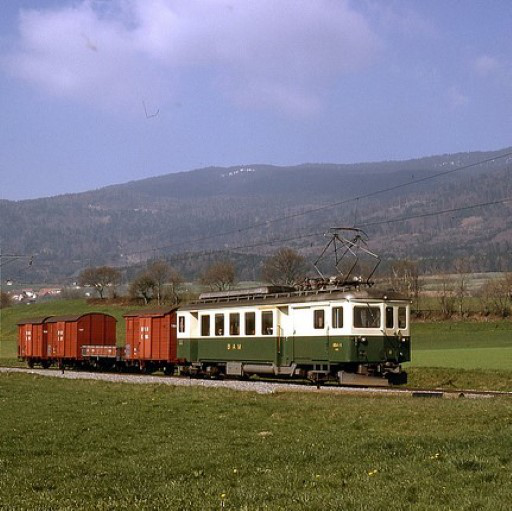

In [19]:
init_image = Image.open("/content/img0.jpg").convert("RGB")
init_image 

In [25]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

from torch import autocast

#pipe = StableDiffusionPipeline.from_pretrained(
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float16,
    text_encoder=text_encoder,
    init_image=init_image,
    tokenizer=tokenizer,
    use_auth_token=True,
    crop = True,
).to("cuda")
prompt = "Graffiti depicting a heartwarming scene in the style of \u003Cm-mi2i>: three coniferous trees, three mansions, and a mountain range in the distance." #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows*num_samples):
  with autocast("cuda"):
      images = pipe([prompt], size=256,num_inference_steps=50, guidance_scale=7.5,init_image=init_image)["sample"]
      all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

{'trained_betas'} was not found in config. Values will be initialized to default values.


TypeError: ignored

{'trained_betas'} was not found in config. Values will be initialized to default values.


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

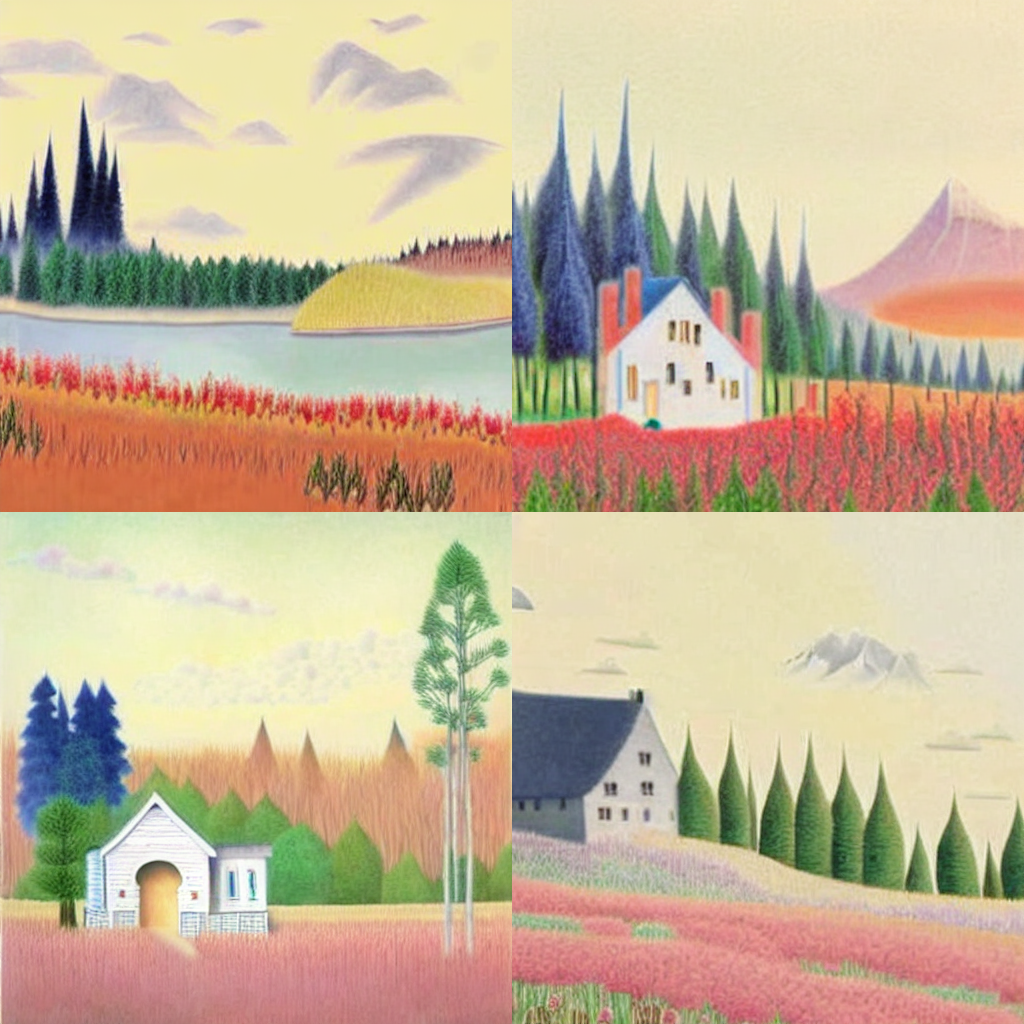

In [ ]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

from torch import autocast

#pipe = StableDiffusionPipeline.from_pretrained(
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float16,
    text_encoder=text_encoder,
    init_image=init_image,
    tokenizer=tokenizer,
    use_auth_token=True,
).to("cuda")
prompt = "Graffiti depicting a heartwarming scene in the style of \u003Cm-mi2i>: three coniferous trees, three mansions, and a mountain range in the distance." #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows*num_samples):
  with autocast("cuda"):
      images = pipe([prompt], num_inference_steps=50, guidance_scale=6.5,init_image=init_image)["sample"]
      all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

In [ ]:
prompt = "a Landscape in \u003Cm-m> style. " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 4 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows*num_samples):
  with autocast("cuda"):
      images = pipe([prompt], num_inference_steps=50, guidance_scale=7.5)["sample"]
      all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

In [ ]:
prompt = "a picture of landscape with many trees in \u003Cm-m> style" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows*num_samples):
  with autocast("cuda"):
      images = pipe([prompt], num_inference_steps=50, guidance_scale=7.5)["sample"]
      all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

In [ ]:
prompt = "a pastel grafitti of landscape of Japan in  delicate  \u003Cm-m> style,  idyllic, with the moon and milky way in the sky,, many trees and mountain in distance" #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows*num_samples):
  with autocast("cuda"):
      images = pipe([prompt], num_inference_steps=50, guidance_scale=7.5)["sample"]
      all_images.extend(images)

grid = image_grid(all_images, num_rows,num_samples)
grid

In [ ]:
prompt = "a pastel grafitti of landscape in  delicate  \u003Cm-m> style,  a church and a harbor, idyllic, with the moon and milky way in the sky, many trees and mountain in distance" #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows*num_samples):
  with autocast("cuda"):
      images = pipe([prompt], num_inference_steps=50, guidance_scale=7.5)["sample"]
      all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid